
Transfer Learning: Detection of Protesting Events
=======================================

**Model adapted from:** https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

**Original Author:** `Sasank Chilamkurthy <https://chsasank.github.io>`

**License:** BSD

**Transfer Learning Models:**

Two major transfer learning scenarios are examined here:

1. **Fine-tuning the Convolutional Neural Network** by replacing random initialization with a pretrained network, carry out training using backpropagation and cost function minimization using Stochastic Gradient Descent. 


2. **Using CNN as a fixed feature extractor** by freezing the weights for all the network except ones of the final fully connected layer. The weights in the last layer is replaced with new random weights and only this layer is trained. 

**Tools Used:** 

PyTorch, ResNet-18

In [18]:
%matplotlib inline

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------
**Input Dataset Structure:**
- train
    - protest: 200 samples
    - no_protest: 200 samples
- validation
    - protest: 80 samples
    - no_protest: 80 samples
    
(Samples used in train and validation are all retrieved from the 'news_imgs/train' folder. Code used can be found in file: *pre-processing.ipynb*)

In [20]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'protest' #make sure this file is located in same directory as dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Visualizing training images**: data augmentations. 

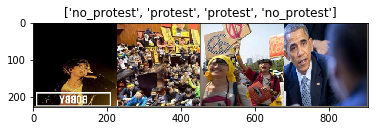

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

-  Run 25 epochs, each compose of a training and validation phrase; generate Loss and Accuracy measurements
-  Scheduling the learning rate
-  Saving the best model using deepcopy
-  ``scheduler`` is an LR scheduler object from ``torch.optim.lr_scheduler``.

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Visualizing model predictions**

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Fine-tuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

**Train and evaluate**

Here running time's based on running task on CPU.

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7841 Acc: 0.6300
val Loss: 0.3880 Acc: 0.8250

Epoch 1/24
----------
train Loss: 0.7419 Acc: 0.6925
val Loss: 0.5236 Acc: 0.7562

Epoch 2/24
----------
train Loss: 0.7274 Acc: 0.6175
val Loss: 0.5245 Acc: 0.7750

Epoch 3/24
----------
train Loss: 0.6382 Acc: 0.7050
val Loss: 0.3659 Acc: 0.8688

Epoch 4/24
----------
train Loss: 0.8081 Acc: 0.6800
val Loss: 0.4512 Acc: 0.8000

Epoch 5/24
----------
train Loss: 0.5927 Acc: 0.7450
val Loss: 0.5915 Acc: 0.8000

Epoch 6/24
----------
train Loss: 0.7345 Acc: 0.7125
val Loss: 0.6634 Acc: 0.7750

Epoch 7/24
----------
train Loss: 0.5200 Acc: 0.7775
val Loss: 0.4974 Acc: 0.7812

Epoch 8/24
----------
train Loss: 0.4607 Acc: 0.7950
val Loss: 0.4130 Acc: 0.8125

Epoch 9/24
----------
train Loss: 0.4076 Acc: 0.8100
val Loss: 0.4100 Acc: 0.8125

Epoch 10/24
----------
train Loss: 0.3688 Acc: 0.8325
val Loss: 0.3960 Acc: 0.8187

Epoch 11/24
----------
train Loss: 0.3916 Acc: 0.8325
val Loss: 0.4014 Acc: 0.8313

Ep

From the result above, we can see that training loss has some overall fluctuations, but reaching last epoch, the train loss is at its minimum, and accuracy is at its highest. Best Validation Accuracy achieved with this model is 0.868750. Training completed in 42 minutes is because the model's run on CPU, would have been much faster on a GPU. 

Visualizing Results:

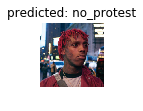

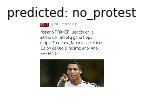

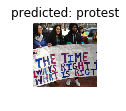

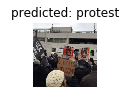

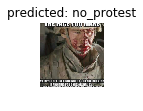

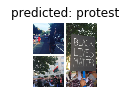

In [15]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Freeze all the network except the final layer by setting ``requires_grad == False`` to freeze the parameters so that the gradients are not computed in ``backward()``.

In [16]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate:

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9199 Acc: 0.5725
val Loss: 0.4186 Acc: 0.7812

Epoch 1/24
----------
train Loss: 0.7340 Acc: 0.6500
val Loss: 0.4075 Acc: 0.8000

Epoch 2/24
----------
train Loss: 0.6478 Acc: 0.6975
val Loss: 0.4607 Acc: 0.7500

Epoch 3/24
----------
train Loss: 0.6483 Acc: 0.6850
val Loss: 0.3825 Acc: 0.8313

Epoch 4/24
----------
train Loss: 0.6017 Acc: 0.7050
val Loss: 0.5540 Acc: 0.7750

Epoch 5/24
----------
train Loss: 0.8897 Acc: 0.6075
val Loss: 0.4207 Acc: 0.8125

Epoch 6/24
----------
train Loss: 0.6035 Acc: 0.7075
val Loss: 0.4330 Acc: 0.8063

Epoch 7/24
----------
train Loss: 0.5588 Acc: 0.7350
val Loss: 0.4339 Acc: 0.8125

Epoch 8/24
----------
train Loss: 0.5237 Acc: 0.7350
val Loss: 0.4348 Acc: 0.8063

Epoch 9/24
----------
train Loss: 0.5069 Acc: 0.7750
val Loss: 0.4076 Acc: 0.8063

Epoch 10/24
----------
train Loss: 0.5219 Acc: 0.7575
val Loss: 0.3853 Acc: 0.8375

Epoch 11/24
----------
train Loss: 0.5262 Acc: 0.7550
val Loss: 0.4648 Acc: 0.8000

Ep

Best Validation Accuracy achieved: 0.837500

Visualizing Results:

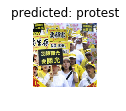

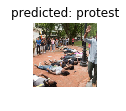

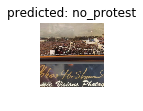

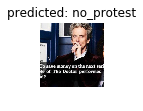

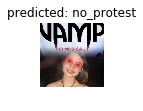

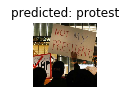

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()